## 【GAN】Large Scale GAN Training for High Fidelity Natural Image Synthesis 论文复现

In [19]:
#解压数据集
#数据路径 data/data39555/cifar-10-batches-py/
%cd data/data39555/
!tar -xzvf cifar-10.tar.gz

[Errno 2] No such file or directory: 'data/data39555/'
/home/aistudio/data/data39555
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [1]:
#解压数据集
#数据路径 data/data39555/cifar-10-batches-py/
# 终端环境配置（训练需要1.8.2，修复了一个致命错误），Notebook不知道怎么配置
!pip install paddlepaddle_gpu-1.8.2.post97
!tar -xzvf data/data39555/cifar-10.tar.gz
!export default LD_LIBRARY_PATH=$HOME/cuda/lib64:$LD_LIBRARY_PATH

Looking in indexes: https://mirror.baidu.com/pypi/simple/
  ERROR: Could not find a version that satisfies the requirement paddlepaddle_gpu-1.8.2.post97 (from versions: none)
ERROR: No matching distribution found for paddlepaddle_gpu-1.8.2.post97
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


**模型定义**

In [2]:
import numpy as np
from scipy.stats import truncnorm
import paddle
import paddle.fluid as fluid
from paddle.fluid import layers, dygraph as dg
from paddle.fluid.initializer import Normal, Constant, Uniform


def l2normalize(v, eps=1e-4):
  return layers.l2_normalize(v, -1, epsilon=eps)
 
class ReLU(dg.Layer):
  def forward(self, x):
    return layers.relu(x)
    
 
class SoftMax(dg.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.kwargs = kwargs
  
  def forward(self, x):
    return layers.softmax(x, **self.kwargs)
 
 
# 此批归一化增加了累计平均和累计方差功能，在完成训练后，验证过程前，
# 开启累计过程，在多个step下估计更准确的平均和方差
class BatchNorm(dg.BatchNorm):
  def __init__(self, *args, **kwargs):
    if 'affine' in kwargs:
      affine = kwargs.pop('affine')
      if not affine:
        kwargs['param_attr'] = fluid.ParamAttr(initializer=fluid.initializer.Constant(value=1.0), trainable=False)
        kwargs['bias_attr'] = fluid.ParamAttr(initializer=fluid.initializer.Constant(value=0.0), trainable=False)
    else:
      affine = True
    
    super().__init__(*args, **kwargs)
    self.affine = affine
    self.initialized = False
    self.accumulating = False
    self.accumulated_mean = self.create_parameter(shape=[args[0]], default_initializer=Constant(0.0))
    self.accumulated_var = self.create_parameter(shape=[args[0]], default_initializer=Constant(0.0))
    self.accumulated_counter = self.create_parameter(shape=[1], default_initializer=Constant(1e-12))
    self.accumulated_mean.trainable = False
    self.accumulated_var.trainable = False
    self.accumulated_counter.trainable = False

  def forward(self, inputs, *args, **kwargs):
    if not self.initialized:
      self.check_accumulation()
      self.set_initialized(True)
    if self.accumulating:
      self.eval()
      with dg.no_grad():
        axes = [0] + ([] if len(inputs.shape) == 2 else list(range(2,len(inputs.shape))))
        _mean = layers.reduce_mean(inputs, axes, keep_dim=True)
        mean = layers.reduce_mean(inputs, axes, keep_dim=False)
        var = layers.reduce_mean((inputs-_mean)**2, axes)
        self.accumulated_mean.set_value((self.accumulated_mean*self.accumulated_counter + mean) / (self.accumulated_counter + 1))
        self.accumulated_var.set_value((self.accumulated_var*self.accumulated_counter + var) / (self.accumulated_counter + 1))
        self.accumulated_counter.set_value(self.accumulated_counter + 1)
        _mean = self._mean*1.0
        _variance = self.variance*1.0
        self._mean.set_value(self.accumulated_mean)
        self._variance.set_value(self.accumulated_var)
        out = super().forward(inputs, *args, **kwargs)
        self._mean.set_value(_mean)
        self._variance.set_value(_variance)
        return out
    out = super().forward(inputs, *args, **kwargs)
    return out

  def check_accumulation(self):
    if self.accumulated_counter.numpy().mean() > 1-1e-12:
      self._mean.set_value(self.accumulated_mean)
      self._variance.set_value(self.accumulated_var)
      return True
    return False

  def clear_accumulated(self):
    self.accumulated_mean.set_value(self.accumulated_mean*0.0)
    self.accumulated_var.set_value(self.accumulated_var*0.0)
    self.accumulated_counter.set_value(self.accumulated_counter*0.0+1e-2)

  def set_accumulating(self, status=True):
    if status == True:
      self.accumulating = True
    else:
      self.accumulating = False

  def set_initialized(self, status=False):
    if status == False:
      self.initialized = False
    else:
      self.initialized = True
      
  def train(self):
    super().train()
    if self.affine:
      self.weight.stop_gradient = False
      self.bias.stop_gradient = False
    else:
      self.weight.stop_gradient = True
      self.bias.stop_gradient = True
    self._use_global_stats = False
    
  def eval(self):
    super().eval()
    self.weight.stop_gradient = True
    self.bias.stop_gradient = True
    self._use_global_stats = True
 

# 此谱归一化继承自Paddle动态图自身的谱归一化，v权重与tf的实现不同，但是v本身是根据u求的，
# 所以做权重转换时不需要载入v的权重
class SpectralNorm(dg.SpectralNorm):
  def __init__(self, module, weight_name='weight', power_iterations=1, **kwargs):
    weight_shape = getattr(module, weight_name).shape
    if 'dim' not in kwargs:
      if isinstance(module, ( # dg.Conv1D, dg.Conv1DTranspose,
                          dg.Conv2D, dg.Conv2DTranspose,
                          dg.Conv3D, dg.Conv3DTranspose)):
          kwargs['dim'] = 0
      else:
          kwargs['dim'] = 1
    kwargs['power_iters'] = power_iterations
    if 'weight_shape' in kwargs:
      kwargs.pop('weight_shape')
    super().__init__(weight_shape, **kwargs)
    self.weight = getattr(module, weight_name)

    del module._parameters[weight_name]
    self.module = module
    self.weight_name = weight_name
  
  def forward(self, *args, **kwargs):
    weight_norm = super().forward(self.weight)
    setattr(self.module, self.weight_name, weight_norm)
    out = self.module(*args, **kwargs)
    return out


# 以下这个谱归一化参考自PyTorch的实现，但是与PyTorch对比过程中，发现两次matmul后的结果精度相差极大
# class SpectralNorm(dg.Layer):
#   def __init__(self, module, name='weight', power_iterations=1):
#     super().__init__()
#     self.module = module
#     self.name = name
#     self.power_iterations = power_iterations
#     if not self._made_params():
#       self._make_params()

#   def _update_u_v(self):
#     u = getattr(self.module, self.name + "_u")
#     v = getattr(self.module, self.name + "_v")
#     w = getattr(self.module, self.name + "_bar")

#     height = w.shape[0]
#     _w = layers.reshape(w,(height, -1))
#     for _ in range(self.power_iterations):
#       v = l2normalize(layers.matmul(layers.transpose(_w,[1,0]), u))
#       u = l2normalize(layers.matmul(_w, v))

#     sigma = layers.matmul(u,layers.matmul(_w, v))
#     setattr(self.module, self.name, w / sigma)
#     getattr(self.module, self.name + "_u").set_value(u)

#   def _made_params(self):
#     try:
#       getattr(self.module, self.name + "_u")
#       getattr(self.module, self.name + "_v")
#       getattr(self.module, self.name + "_bar")
#       return True
#     except AttributeError:
#       return False

#   def _make_params(self):
#     w = getattr(self.module, self.name)

#     height = w.shape[0]
#     width = layers.reshape(w,(height, -1)).shape[1]

#     u = self.create_parameter(shape=[height], default_initializer=Normal(0, 1))
#     u.stop_gradient = True
#     v = self.create_parameter(shape=[height], default_initializer=Normal(0, 1))
#     u.stop_gradient = True
#     u.set_value(l2normalize(u))
#     v.set_value(l2normalize(v))
#     w_bar = w

#     del self.module._parameters[self.name]
#     self.module.add_parameter(self.name + "_bar", w_bar)
#     self.module.add_parameter(self.name + "_u", u)
#     self.module.add_parameter(self.name + "_v", v)

#   def forward(self, *args):
#     self._update_u_v()
#     return self.module.forward(*args)
    
    
class SelfAttention(dg.Layer):
  def __init__(self, in_dim, activation=layers.relu):
    super().__init__()
    self.chanel_in = in_dim
    self.activation = activation
 
    self.theta = SpectralNorm(dg.Conv2D(in_dim, in_dim // 8, 1, bias_attr=False))
    self.phi = SpectralNorm(dg.Conv2D(in_dim, in_dim // 8, 1, bias_attr=False))
    self.pool = dg.Pool2D(2, 'max', 2)
    self.g = SpectralNorm(dg.Conv2D(in_dim, in_dim // 2, 1, bias_attr=False))
    self.o_conv = SpectralNorm(dg.Conv2D(in_dim // 2, in_dim, 1, bias_attr=False))
    self.gamma = self.create_parameter([1,], default_initializer=Constant(0.0))
 
    self.softmax = SoftMax(axis=-1)
 
  def forward(self, x):
    m_batchsize, C, width, height = x.shape
    N = height * width
 
    theta = self.theta(x)
    phi = self.phi(x)
    phi = self.pool(phi)
    phi = layers.reshape(phi,(m_batchsize, -1, N // 4))
    theta = layers.reshape(theta,(m_batchsize, -1, N))
    theta = layers.transpose(theta,(0, 2, 1))
    attention = self.softmax(layers.bmm(theta, phi))
    g = layers.reshape(self.pool(self.g(x)),(m_batchsize, -1, N // 4))
    attn_g = layers.reshape(layers.bmm(g, layers.transpose(attention,(0, 2, 1))),(m_batchsize, -1, width, height))
    out = self.o_conv(attn_g)
    return self.gamma * out + x
 
 
class ConditionalBatchNorm(dg.Layer):
  def __init__(self, num_features, num_classes, epsilon=1e-4, momentum=0.1):
    super().__init__()
    self.num_features = num_features
    self.gamma_embed = SpectralNorm(dg.Linear(num_classes, num_features, bias_attr=False))
    self.beta_embed = SpectralNorm(dg.Linear(num_classes, num_features, bias_attr=False))
    self.bn_in_cond = BatchNorm(num_features, affine=False, epsilon=epsilon, momentum=momentum)
 
  def forward(self, x, y):
    gamma = self.gamma_embed(y) + 1
    beta = self.beta_embed(y)
    out = self.bn_in_cond(x)
    out = layers.reshape(gamma, (-1, self.num_features, 1, 1)) * out + layers.reshape(beta, (-1, self.num_features, 1, 1))
    return out
 

class ResBlock(dg.Layer):
  def __init__(
    self,
    in_channel,
    out_channel,
    kernel_size=[3, 3],
    padding=1,
    stride=1,
    n_class=None,
    conditional=True,
    activation=layers.relu,
    upsample=True,
    downsample=False,
    z_dim=128,
    use_attention=False
  ):
    super().__init__()
 
    if conditional:
      self.cond_norm1 = ConditionalBatchNorm(in_channel, z_dim)
 
    self.conv0 = SpectralNorm(
      dg.Conv2D(in_channel, out_channel, kernel_size, stride, padding)
    )
 
    if conditional:
      self.cond_norm2 = ConditionalBatchNorm(out_channel, z_dim)
 
    self.conv1 = SpectralNorm(
      dg.Conv2D(out_channel, out_channel, kernel_size, stride, padding)
    )
 
    self.skip_proj = False
    if in_channel != out_channel or upsample or downsample:
      self.conv_sc = SpectralNorm(dg.Conv2D(in_channel, out_channel, 1, 1, 0))
      self.skip_proj = True
 
    if use_attention:
      self.attention = SelfAttention(out_channel)
 
    self.upsample = upsample
    self.downsample = downsample
    self.activation = activation
    self.conditional = conditional
    self.use_attention = use_attention
 
  def forward(self, input, condition=None):
    out = input
 
    if self.conditional:
      out = self.cond_norm1(out, condition)
    out = self.activation(out)
    if self.upsample:
      out = layers.interpolate(out, scale=2)
    out = self.conv0(out)
    if self.conditional:
      out = self.cond_norm2(out, condition)
    out = self.activation(out)
    out = self.conv1(out)
 
    if self.downsample:
      out = layers.pool2d(out, 2, pool_type='avg', pool_stride=2)
 
    if self.skip_proj:
      skip = input
      if self.upsample:
        skip = layers.interpolate(skip, scale=2, resample='NEAREST')
      skip = self.conv_sc(skip)
      if self.downsample:
        skip = layers.pool2d(skip, 2, pool_type='avg', pool_stride=2)
    else:
      skip = input
 
    out = out + skip
 
    if self.use_attention:
      out = self.attention(out)
 
    return out
 
 
class Generator(dg.Layer):
  def __init__(self, code_dim=128, n_class=1000, chn=96, blocks_with_attention="B4", resolution=512):
    super().__init__()
 
    def GBlock(in_channel, out_channel, n_class, z_dim, use_attention):
      return ResBlock(in_channel, out_channel, n_class=n_class, z_dim=z_dim, use_attention=use_attention)
 
    self.embed_y = dg.Linear(n_class, 128, bias_attr=False)
 
    self.chn = chn
    self.resolution = resolution 
    self.blocks_with_attention = set(blocks_with_attention.split(",")) 
    self.blocks_with_attention.discard('')
 
    gblock = []
    in_channels, out_channels = self.get_in_out_channels()
    self.num_split = len(in_channels) + 1
 
    z_dim = code_dim//self.num_split + 128
    self.noise_fc = SpectralNorm(dg.Linear(code_dim//self.num_split, 4 * 4 * in_channels[0]))
 
    self.sa_ids = [int(s.split('B')[-1]) for s in self.blocks_with_attention]
 
    for i, (nc_in, nc_out) in enumerate(zip(in_channels, out_channels)):
      gblock.append(GBlock(nc_in, nc_out, n_class=n_class, z_dim=z_dim, use_attention=(i+1) in self.sa_ids))
    self.blocks = dg.LayerList(gblock)
 
    self.output_layer = dg.Sequential(
      BatchNorm(1 * chn, epsilon=1e-4),
      ReLU(), 
      SpectralNorm(dg.Conv2D(1 * chn, 3, [3, 3], padding=1))
    )
 
  def get_in_out_channels(self):
    resolution = self.resolution
    if resolution == 512:
      channel_multipliers = [16, 16, 8, 8, 4, 2, 1, 1]
    elif resolution == 256:
      channel_multipliers = [16, 16, 8, 8, 4, 2, 1]
    elif resolution == 128:
      channel_multipliers = [16, 16, 8, 4, 2, 1]
    elif resolution == 64:
      channel_multipliers = [16, 16, 8, 4, 2]
    elif resolution == 32:
      channel_multipliers = [4, 4, 4, 4]
    else:
      raise ValueError("Unsupported resolution: {}".format(resolution))
    in_channels = [self.chn * c for c in channel_multipliers[:-1]]
    out_channels = [self.chn * c for c in channel_multipliers[1:]]
    return in_channels, out_channels
 
  def forward(self, input, class_id):
    codes = layers.split(input, self.num_split, 1)
    class_emb = self.embed_y(class_id)  # 128
    out = self.noise_fc(codes[0])
    # out = layers.transpose(layers.reshape(out,(out.shape[0], 4, 4, -1)),(0, 3, 1, 2))
    out = layers.reshape(out,(out.shape[0], -1, 4, 4)) # for tf pretrained model, use transpose to weight
    for i, (code, gblock) in enumerate(zip(codes[1:], self.blocks)):
      condition = layers.concat([code, class_emb], 1)
      out = gblock(out, condition)
 
    out = self.output_layer(out)
    return layers.tanh(out)
 
 
class Discriminator(dg.Layer):
  def __init__(self, n_class=1000, chn=96, blocks_with_attention="B2", resolution=256): 
    super().__init__()
 
    def DBlock(in_channel, out_channel, downsample=True, use_attention=False):
      return ResBlock(in_channel, out_channel, conditional=False, upsample=False, downsample=downsample, use_attention=use_attention)
 
    self.chn = chn
    self.resolution = resolution  
    self.blocks_with_attention = set(blocks_with_attention.split(",")) 
    self.blocks_with_attention.discard('')
 
    self.pre_conv = dg.Sequential(
      SpectralNorm(dg.Conv2D(3, 1 * chn, 3, padding=1)),
      ReLU(),
      SpectralNorm(dg.Conv2D(1 * chn, 1 * chn, 3, padding=1)),
      dg.Pool2D(2, pool_type='avg', pool_stride=2),
    )
    self.pre_skip = SpectralNorm(dg.Conv2D(3, 1 * chn, 1))
 
    dblock = []
    in_channels, out_channels = self.get_in_out_channels()
 
    self.sa_ids = [int(s.split('B')[-1]) for s in self.blocks_with_attention]
 
    for i, (nc_in, nc_out) in enumerate(zip(in_channels[:-1], out_channels[:-1])):
      dblock.append(DBlock(nc_in, nc_out, downsample=True, use_attention=(i+1) in self.sa_ids))
    dblock.append(DBlock(in_channels[-1], out_channels[-1], downsample=False, use_attention=len(out_channels) in self.sa_ids))
    self.blocks = dg.LayerList(dblock)
 
    for sa_id in self.sa_ids:
      setattr(self, f'attention_{sa_id}', SelfAttention(in_channels[sa_id]))
 
    self.final_fc = SpectralNorm(dg.Linear(16 * chn, 1))
 
    self.embed_y = dg.Embedding(size=[n_class, 16 * chn], is_sparse=False, param_attr=Uniform(-0.1,0.1))
    self.embed_y = SpectralNorm(self.embed_y)
 
  def get_in_out_channels(self):
    resolution = self.resolution
    if resolution == 512:
      channel_multipliers = [1, 1, 2, 4, 8, 8, 16, 16]
    elif resolution == 256:
      channel_multipliers = [1, 2, 4, 8, 8, 16, 16]
    elif resolution == 128:
      channel_multipliers = [1, 2, 4, 8, 16, 16]
    elif resolution == 64:
      channel_multipliers = [2, 4, 8, 16, 16]
    elif resolution == 32:
      channel_multipliers = [2, 2, 2, 2]
    else:
      raise ValueError("Unsupported resolution: {}".format(resolution))
    in_channels = [self.chn * c for c in channel_multipliers[:-1]]
    out_channels = [self.chn * c for c in channel_multipliers[1:]]
    return in_channels, out_channels
 
  def forward(self, input, class_id):
 
    out = self.pre_conv(input)
    out += self.pre_skip(layers.pool2d(input, 2, pool_type='avg', pool_stride=2))
    for i, dblock in enumerate(self.blocks):
      out = dblock(out)
    out = layers.relu(out)
    out = layers.reshape(out,(out.shape[0], out.shape[1], -1))
    out = layers.reduce_sum(out, 2)
    out_linear = layers.squeeze(self.final_fc(out), [1])
    class_emb = self.embed_y(class_id)
 
    prod = layers.reduce_sum((out * class_emb), 1)
 
    return out_linear + prod

In [3]:
# 动态图版本的EMA，使得模型权重更加平滑（本身不参与训练，不修改模型权重，平滑后的权重存储于EMA自身）
# 训练中断时应另外定义一个方法存储EMA中的权重
class EMA:
  def __init__(self, model, decay=0.999):
    self.model = model
    self.decay = decay
    self.shadow = {}
    self.backup = {}

  def register(self):
    for (name, param) in self.model.named_parameters():
      if not param.stop_gradient:
        self.shadow[name] = (param * 1).detach()

  def update(self):
    for (name, param) in self.model.named_parameters():
      if not param.stop_gradient:
        assert name in self.shadow
        new_average = (1.0 - self.decay) * param + self.decay * self.shadow[name]
        self.shadow[name] = (new_average * 1).detach()

  def apply_shadow(self):
    for (name, param) in self.model.named_parameters():
      if not param.stop_gradient:
        assert name in self.shadow
        self.backup[name] = param
        param.set_value(self.shadow[name])

  def restore(self):
    for (name, param) in self.model.named_parameters():
      if not param.stop_gradient:
        assert name in self.backup
        param.set_value(self.backup[name])
    self.backup = {}

**下载tensorflow权重验证模型是否一致**

In [4]:
!cat tf_weights.zip.* > tf_weights.zip
!unzip tf_weights.zip

Archive:  tf_weights.zip
  inflating: tf_weights.pkl          


In [1]:
# 下载tf权重，保存进pkl，后面的内容应该在aistudio上都无法操作
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

module_path = 'https://tfhub.dev/deepmind/biggan-256/2'
tf.reset_default_graph()
hub.Module(module_path)
print('Loaded BigGAN module from:', module_path)

initializer = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initializer)

var_list = []
for var in tf.global_variables():
  val = sess.run(var)
  var_list.append([var.name, val])

import pickle
f = open('tf_weights.pkl', 'wb')
pickle.dump(var_list, f)
f.close()

Cannot run import tensorflow because of system compatibility. AI Studio prepared an entire environment based on PaddlePaddle already. Please use PaddlePaddle to build your own model or application.


In [4]:
# 创建paddle动态图模型
place = fluid.CUDAPlace(fluid.dygraph.ParallelEnv().dev_id)
fluid.enable_dygraph(place)
 
# g_128 = Generator(code_dim=120, n_class=1000, chn=96, blocks_with_attention="B4", resolution=128)
# x = layers.randn([2,120])
# y = layers.randint(0,1000,shape=[2])
# y_hot = layers.one_hot(layers.unsqueeze(y,[1]), depth=1000)
# img = g_128(x, y_hot)
# print(img.shape)
# d_128 = Discriminator(n_class=1000, chn=96, blocks_with_attention="B2", resolution=128)
# pred = d_128(img, y)
# print(pred.shape)
 
g_256 = Generator(code_dim=140, n_class=1000, chn=96, blocks_with_attention="B5", resolution=256)
x = layers.randn([2,140])
y = layers.randint(0,1000,shape=[2])
y_hot = layers.one_hot(layers.unsqueeze(y,[1]), depth=1000)
img = g_256(x, y_hot)
print(img.shape)
d_256 = Discriminator(n_class=1000, chn=96, blocks_with_attention="B2", resolution=256)
pred = d_256(img, y)
print(pred.shape)
 
# g_512 = Generator(code_dim=128, n_class=1000, chn=96, blocks_with_attention="B4", resolution=512)
# x = layers.randn([2,128])
# y = layers.randint(0,1000,shape=[2])
# y_hot = layers.one_hot(layers.unsqueeze(y,[1]), depth=1000)
# img = g_512(x, y_hot)
# print(img.shape)
# d_512 = Discriminator(n_class=1000, chn=96, blocks_with_attention="B2", resolution=512)
# pred = d_512(img, y)
# print(pred.shape)

[2, 3, 256, 256]
[2]


In [5]:
!ls

757442.ipynb  data  tf_weights.pkl  tf_weights.zip  work


In [5]:
# 定义完全顺序化的权重转换，
# 权重中谱归一化的u1:0和u2:0不参与转换，本身应该是u0:0运算后的结果

import pickle
f = open('tf_weights.pkl', 'rb')
tf_weights = pickle.load(f)

def tf_filter(x):
  if 'u1:0' in x[0] or 'u2:0' in x[0]:
    return False
  return True

tf_weights = filter(tf_filter, tf_weights)

def pd_filter(x):
  if 'weight_v' in x[0] or '._mean' in x[0] or '._variance' in x[0] \
    or '.bn_in_cond.weight' in x[0] or '.bn_in_cond.bias' in x[0]:
    return False
  return True

_pd_params = list(filter(pd_filter, g_256.named_parameters()))
pd_params = []
for i, params in enumerate(_pd_params): # 此处为纠正顺序，与tf的权重完全对应
  b_continue = False
  for j in range(8):
    if 'attention.gamma' in _pd_params[i-j][0]:
      pd_params.append(_pd_params[i+1])
      b_continue = True
  if b_continue:
    continue
  if 'attention.gamma' in _pd_params[i-8][0]:
    pd_params.append(_pd_params[i-8])
    continue
  if 'output_layer.0.weight' in params[0]:
    pd_params.append(_pd_params[i+1])
    continue
  if 'output_layer.0.bias' in params[0]:
    pd_params.append(_pd_params[i-1])
    continue
  pd_params.append(params)

_pd_params = pd_params
pd_params = []
for i, params in enumerate(_pd_params):
  if 'weight_u' in params[0]:
    pd_params.append(_pd_params[i+1])
    continue
  if 'weight_u' in _pd_params[i-1][0]:
    pd_params.append(_pd_params[i-1])
    continue
  pd_params.append(params)


for i, (tf_weight, pd_param) in enumerate(zip(tf_weights, pd_params)):
  if len(pd_param[1].shape) == 4:
    weight = tf_weight[1].transpose([3, 2, 0, 1])
  elif 'noise_fc.weight' in pd_param[0]:
    weight = tf_weight[1].reshape([tf_weight[1].shape[0], 4, 4, -1]).transpose([0, 3, 1, 2]).reshape(pd_param[1].shape)
  elif 'noise_fc.bias' in pd_param[0]:
    weight = tf_weight[1].reshape([4, 4, -1]).transpose([2, 0, 1])
  else:
    weight = tf_weight[1].reshape(pd_param[1].shape)
  pd_param[1].set_value(weight)
  print(tf_weight[0], tf_weight[1].shape, pd_param[0], pd_param[1].shape)

module/linear/w:0 (1000, 128) embed_y.weight [1000, 128]
module/Generator/G_Z/G_linear/w:0 (20, 24576) noise_fc.weight [20, 24576]
module/Generator/G_Z/G_linear/u0:0 (1, 24576) noise_fc.weight_u [24576]
module/Generator/G_Z/G_linear/b:0 (24576,) noise_fc.module.bias [24576]
module/Generator/GBlock/HyperBN/gamma/w:0 (148, 1536) blocks.0.cond_norm1.gamma_embed.weight [148, 1536]
module/Generator/GBlock/HyperBN/gamma/u0:0 (1, 1536) blocks.0.cond_norm1.gamma_embed.weight_u [1536]
module/Generator/GBlock/HyperBN/beta/w:0 (148, 1536) blocks.0.cond_norm1.beta_embed.weight [148, 1536]
module/Generator/GBlock/HyperBN/beta/u0:0 (1, 1536) blocks.0.cond_norm1.beta_embed.weight_u [1536]
module/Generator/GBlock/CrossReplicaBN/accumulated_mean:0 (1536,) blocks.0.cond_norm1.bn_in_cond.accumulated_mean [1536]
module/Generator/GBlock/CrossReplicaBN/accumulated_var:0 (1536,) blocks.0.cond_norm1.bn_in_cond.accumulated_var [1536]
module/Generator/GBlock/CrossReplicaBN/accumulation_counter:0 () blocks.0.con

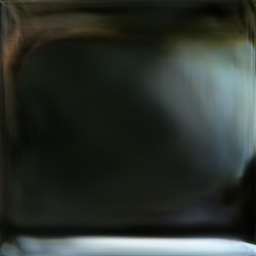

In [6]:
# 检验转换结果（失败了）
for _layers in g_256.named_sublayers():
  class_name = _layers[1].__class__.__name__
  if 'BatchNorm' == class_name:
    _layers[1].set_initialized(False) # 修改批归一化的初始状态为False，使其能够使用累计平均和方差的权重

g_256.eval()
x = layers.randn([2,140])
y = layers.randint(0,1000,shape=[2])
y_hot = layers.one_hot(layers.unsqueeze(y,[1]), depth=1000)
img = g_256(x, y_hot)
img = np.uint8((g_256(x, y_hot).numpy()[0].transpose(1,2,0).clip(-1,1)+1)/2*255)
from PIL import Image
Image.fromarray(img) # 奇怪的图像，有一些感觉了，但完全不对

In [7]:
# 与pytorch进行操作对比，发现精度差很多，所有没有使用pytorch的谱归一化
w = np.random.randn(768,1536,3,3)*200
u = np.random.randn(768)*100
height = w.shape[0]
def pd(w, u):
  _w = layers.reshape(w,(height, -1))
  for _ in range(1):
    xx = layers.matmul(layers.transpose(_w,[1,0]), u)
    v = l2normalize(layers.matmul(layers.transpose(_w,[1,0]), u))
    u = l2normalize(layers.matmul(_w, v))

  wv = layers.matmul(u, _w)
  sigma = layers.matmul(u,layers.matmul(_w, v))
  return v.numpy(), u.numpy(), sigma.numpy(), xx.numpy(), wv.numpy(), _w.numpy()

def th(w, u):
  _w = w.view(height, -1)
  for _ in range(1):
    xx = torch.matmul(_w.t(), u)
    v = t_l2normalize(torch.matmul(_w.t(), u))
    u = t_l2normalize(torch.matmul(_w, v))

  wv = torch.matmul(u, _w) # (_w).mv(v)
  sigma = u.dot((_w).mv(v))
  return v.detach().cpu().numpy(), u.detach().cpu().numpy(), sigma.detach().cpu().numpy(), xx.detach().cpu().numpy(), wv.detach().cpu().numpy(), _w.detach().cpu().numpy()

pd_v, pd_u, pd_sigma, pd_xx, pd_wv, pd_w = pd(dg.to_variable(w.astype('float32')), dg.to_variable(u.astype('float32')))
th_v, th_u, th_sigma, th_xx, th_wv, th_w = th(torch.cuda.FloatTensor(w), torch.cuda.FloatTensor(u))
print(pd_sigma - th_sigma, pd_wv.shape, pd_wv.shape)

NameError: name 'torch' is not defined

In [8]:
!ls

757442.ipynb  cifar-10-batches-py  data  tf_weights.pkl  work
